# Objetivo

Aqui vamos atuar em cima das bases mensais para calcular conceitos e avaliações fundamentalistas. São elas:
- DY próximo de 10%
- P/VP Abaixo de 1.0 é um bom indicativo
- Baixa oscilação

## Bibliotecas

In [1]:
# Geral
import warnings
import numpy as np
import pandas as pd
from datetime import datetime

# Plots
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Remover warnings chatos do pandas
warnings.filterwarnings("ignore")

# Funções

In [2]:
def calcular_preco_graham_setor(pl, pvp, lpa, vpa):
    # Calcular valor
    val = pl * pvp * lpa * vpa
    if val > 0:
        return round(np.sqrt(val), 2)
    else:
        return np.nan

In [3]:
def calcular_razao(v1, v2):
    if v1 == 0 or v2 == 0:
        return 0
    else:
        return v1 / v2

# Execução

In [4]:
# Carregar base(s)
path_file = f'dados/2_TRA/fii_tratado_fundamentus_2023-12-26.csv'
df = pd.read_csv(path_file)

In [5]:
# Filtrar apenas aqueles com informações de atributo
filtro = df[['FII','NOME','MANDATO','SEGMENTO','GESTAO']].notnull().sum(axis=1) == 5
df = df[filtro].reset_index(drop=True).copy()

In [6]:
# Calcular Razão de cotação / dividendo por cota
# Quantidade de cotas que preciso ter para reaver uma nova cota através apenas de dividendos
# Quanto menor, melhor!
df['RAZAO_COTACAO_DIVIDENDO'] = df.apply(lambda df: calcular_razao(df['COTACAO'], df['DIVIDENDO_POR_COTA']), axis=1)

**Agregados por setor necessários**

In [7]:
# Gerar agregados
indicadores = ['P_POR_VP', 'DIV_YIELD', 'RAZAO_COTACAO_DIVIDENDO', 'DIVIDENDO_POR_COTA']
df_agg = df[['SEGMENTO'] + indicadores].groupby('SEGMENTO').median().reset_index()

In [8]:
# Modificar colunas
df_agg.columns = [c if c == 'SEGMENTO' else f'AGG_{c}' for c in df_agg.columns]

In [9]:
# Unificar informações na base
df = pd.merge(df, df_agg, on='SEGMENTO', how='left')

**Criar Flags**

In [10]:
df['FLAG_DY_ACIMA_10'] = (df['DIV_YIELD'] >= 10).astype(int)

In [11]:
df['FLAG_DY_ACIMA_DY_SETOR'] = (df['DIV_YIELD'] >= df['AGG_DIV_YIELD']).astype(int)

**Avaliação de Carteira**

In [12]:
# Definir papeis atuais a partir da carteira e seus setores
papeis_atuais = ['BTLG11','CVBI11','KNRI11','MALL11','MCCI11','VRTA11','XPML11']
setores_atuais = df.loc[df['FII'].isin(papeis_atuais), 'SEGMENTO'].unique().tolist()

In [13]:
# Criar dataframe de análise
df_aval = df.loc[df['SEGMENTO'].isin(setores_atuais)] 

In [14]:
# Flag para apontar papeis de sua carteira
df_aval['CARTEIRA'] = df_aval['FII'].isin(papeis_atuais).astype(int).copy()

In [15]:
# Definir colunas de analise
cols = ['FII','SEGMENTO','COTACAO', 'OSCILACOES_%_2023'] + indicadores + [f'AGG_{i}' for i in indicadores]
cols += [c for c in df.columns if 'FLAG' in c]

In [16]:
# Criar coluna de flags
df_aval['FLAG_DY_ACIMA_10_E_SETOR'] = (df_aval['FLAG_DY_ACIMA_10'] == True)&(df_aval['FLAG_DY_ACIMA_DY_SETOR'] == True)

In [17]:
# Visualizar
df_aval.loc[df_aval['CARTEIRA'] == 1, cols]

,FII,SEGMENTO,COTACAO,OSCILACOES_%_2023,P_POR_VP,DIV_YIELD,RAZAO_COTACAO_DIVIDENDO,DIVIDENDO_POR_COTA,AGG_P_POR_VP,AGG_DIV_YIELD,AGG_RAZAO_COTACAO_DIVIDENDO,AGG_DIVIDENDO_POR_COTA,FLAG_DY_ACIMA_10,FLAG_DY_ACIMA_DY_SETOR
13,BTLG11,Híbrido,99.89,8.19,1.02,8.5,13.835180,7.22,0.930,9.30,10.155556,6.840,0,0
42,KNRI11,Híbrido,161.01,23.62,1.01,7.2,13.384040,12.03,0.930,9.30,10.155556,6.840,0,0
203,MALL11,Shoppings,114.98,20.48,0.96,8.0,12.128692,9.48,0.840,8.05,11.649395,8.515,0,0
210,XPML11,Shoppings,113.56,29.26,1.01,8.1,14.652903,7.75,0.840,8.05,11.649395,8.515,0,1
236,CVBI11,Títulos e Val. Mob.,90.05,17.41,0.94,12.5,7.961981,11.31,0.935,12.10,8.125014,9.430,1,1
275,MCCI11,Títulos e Val. Mob.,91.07,16.28,0.97,12.9,7.850862,11.60,0.935,12.10,8.125014,9.430,1,1
327,VRTA11,Títulos e Val. Mob.,88.00,10.18,0.95,11.0,8.527132,10.32,0.935,12.10,8.125014,9.430,1,0


In [18]:
# Visualizar um segmento específico
df_aval.loc[df_aval['SEGMENTO'] == 'Shoppings', cols]

,FII,SEGMENTO,COTACAO,OSCILACOES_%_2023,P_POR_VP,DIV_YIELD,RAZAO_COTACAO_DIVIDENDO,DIVIDENDO_POR_COTA,AGG_P_POR_VP,AGG_DIV_YIELD,AGG_RAZAO_COTACAO_DIVIDENDO,AGG_DIVIDENDO_POR_COTA,FLAG_DY_ACIMA_10,FLAG_DY_ACIMA_DY_SETOR
193,ABCP11,Shoppings,69.19,4.95,0.75,8.0,10.250370,6.75,0.84,8.05,11.649395,8.515,0,0
194,ANCR11B,Shoppings,3465.99,3.53,0.95,1.8,57.862938,59.90,0.84,8.05,11.649395,8.515,0,0
195,ATSA11,Shoppings,56.37,-28.39,0.69,0.4,281.850000,0.20,0.84,8.05,11.649395,8.515,0,0
196,FIGS11,Shoppings,60.30,30.89,0.79,8.4,11.334586,5.32,0.84,8.05,11.649395,8.515,0,1
197,FLRP11,Shoppings,1949.99,34.15,1.07,8.2,11.645208,167.45,0.84,8.05,11.649395,8.515,0,1
198,FVPQ11,Shoppings,113.18,14.77,0.59,10.3,9.807626,11.54,0.84,8.05,11.649395,8.515,1,1
199,GSFI11,Shoppings,8.20,64.00,0.57,0.0,0.000000,0.00,0.84,8.05,11.649395,8.515,0,0
200,HGBS11,Shoppings,224.99,28.86,1.00,8.0,11.904233,18.90,0.84,8.05,11.649395,8.515,0,0
201,HPDP11,Shoppings,85.00,22.19,0.95,7.0,13.776337,6.17,0.84,8.05,11.649395,8.515,0,0
202,HSML11,Shoppings,91.85,23.18,0.97,9.0,10.509153,8.74,0.84,8.05,11.649395,8.515,0,1


# Análise Profunda - Estatística

In [29]:
# Bibliotecas
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [20]:
# Definir colunas informativas e indicadores
cols_info = ['FII', 'NOME', 'SEGMENTO','FLAG_DY_ACIMA_10','FLAG_DY_ACIMA_DY_SETOR', 'FLAG_DY_ACIMA_10_E_SETOR', 'CARTEIRA']
cols_indicadores = ['QTD_IMOVEIS','COTACAO','OSCILACOES_%_2023','FFO_12_MESES','FFO_POR_COTA','FFO_YIELD',
                    'DIV_YIELD','P_POR_VP','VP_POR_COTA','DIVIDENDO_POR_COTA','RAZAO_COTACAO_DIVIDENDO',
                    'RECEITA_12_MESES','REND_DISTRIBUIDO_12_MESES','VENDA_DE_ATIVOS_12_MESES']

In [21]:
# Tratar dados
df_analise = df_aval[cols_info + cols_indicadores].copy()

In [22]:
# Checar se temos nulos
df_analise[cols_indicadores].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 0 to 332
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   QTD_IMOVEIS                219 non-null    int64  
 1   COTACAO                    219 non-null    float64
 2   OSCILACOES_%_2023          219 non-null    float64
 3   FFO_12_MESES               219 non-null    int64  
 4   FFO_POR_COTA               219 non-null    float64
 5   FFO_YIELD                  219 non-null    float64
 6   DIV_YIELD                  219 non-null    float64
 7   P_POR_VP                   219 non-null    float64
 8   VP_POR_COTA                219 non-null    float64
 9   DIVIDENDO_POR_COTA         219 non-null    float64
 10  RAZAO_COTACAO_DIVIDENDO    219 non-null    float64
 11  RECEITA_12_MESES           219 non-null    int64  
 12  REND_DISTRIBUIDO_12_MESES  219 non-null    int64  
 13  VENDA_DE_ATIVOS_12_MESES   219 non-null    int64  

In [65]:
# Criar PCA
nc = len(cols_indicadores)
pca = PCA(n_components=nc)
df_pca = df_analise[cols_indicadores].copy()
df_pca = StandardScaler().fit_transform(df_analise[cols_indicadores])
df_pca = pd.DataFrame(pca.fit_transform(df_pca), columns=[f'PC_{i}' for i in range(1, nc+1)])
df_pca = pd.concat([df_analise[cols_info + ['DIV_YIELD', 'P_POR_VP', 'OSCILACOES_%_2023']].reset_index(drop=True), df_pca], axis=1)

In [66]:
# Checar explicação por componente
print(pca.explained_variance_ratio_)

[0.25202993 0.22050789 0.12746024 0.10598624 0.08692784 0.06491781
 0.05018409 0.03487181 0.02708425 0.01705212 0.00892922 0.00245753
 0.00127495 0.00031607]


In [67]:
# Visualizar os dois componentes
fig = px.scatter(df_pca,
                 x="PC_1",
                 y="PC_2",
                 color="FLAG_DY_ACIMA_10_E_SETOR",
                 size='DIV_YIELD',
                 hover_data=['FLAG_DY_ACIMA_10_E_SETOR','FLAG_DY_ACIMA_10','FLAG_DY_ACIMA_DY_SETOR','FII',])
fig.show()

In [68]:
# Pegar explicada acumulada
qtd_pc = (pca.explained_variance_ratio_.cumsum() <= 0.90).sum()
qtd_pc

6

In [69]:
df_pca_cluster = df_pca[[f'PC_{i}' for i in range(1, qtd_pc + 1)]].copy()

In [70]:
df_pca_cluster

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
0,-0.707166,-0.546923,-0.272864,-0.177751,-1.255466,0.151072
1,0.741203,1.340074,-1.864033,1.904342,-0.430736,0.230883
2,-0.682883,-0.626577,-0.298082,0.124879,-0.835893,-0.316001
3,-0.574078,-0.997322,0.280374,0.513709,1.797889,-0.184115
4,19.823512,-5.722782,3.153987,-3.757281,0.058485,0.114474
...,...,...,...,...,...,...
214,-0.706066,-0.875191,-0.017409,-0.057282,0.091445,0.236182
215,-0.449904,-0.928720,0.491514,0.308458,0.022848,0.011439
216,-0.623704,-0.067361,-0.067396,-0.155562,-0.480590,0.179977
217,-0.194201,0.601696,-0.024815,-0.472066,-0.607736,-0.127691


In [71]:
# Lista de clusters possíveis
nc_candidatos = list(range(2, 20, 1))

# Lista para salvar distorções
distorsions = list()

# Loop na possibilidade de grupos
for nc in nc_candidatos:
    # Iniciar objeto
    kmeans = KMeans(n_clusters=nc, random_state=1206, init='k-means++', n_init=25, max_iter=500)
    # Encontrar grupos
    kmeans = kmeans.fit(df_pca_cluster)
    # Salvar distorções para método do cotovelo
    distorsions.append(kmeans.inertia_)

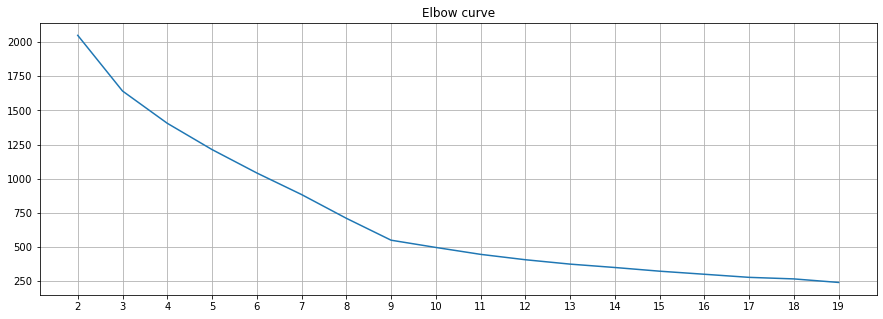

In [72]:
# Visualizar
fig = plt.figure(figsize=(15, 5))
plt.plot(nc_candidatos, distorsions)
plt.xticks(nc_candidatos)
plt.grid(True)
plt.title('Elbow curve');

Pela curva: 9 ou 10 clusters

In [73]:
# Calcular grupos
kmeans = KMeans(n_clusters=9, random_state=1206, init='k-means++', n_init=25, max_iter=500).fit(df_pca_cluster)

In [74]:
# Salvar grupos
df_pca['KMEANS_GRUPOS'] = kmeans.labels_

In [75]:
# Contabilizar grupos
df_pca['KMEANS_GRUPOS'].value_counts()

1    145
2     33
0     24
5      8
7      4
6      2
3      1
4      1
8      1
Name: KMEANS_GRUPOS, dtype: int64

In [77]:
# Visualizar os dois componentes
df_pca['FLAG_DY_ACIMA_DY_SETOR'] = df_pca['FLAG_DY_ACIMA_DY_SETOR'].astype(str) 
fig = px.scatter(df_pca[df_pca['DIV_YIELD'] <= 20],
                 x="DIV_YIELD",
                 y="OSCILACOES_%_2023",
                 color="FLAG_DY_ACIMA_DY_SETOR",
                 color_discrete_sequence=px.colors.qualitative.Antique,
                 size='DIV_YIELD',
                 hover_data=['FLAG_DY_ACIMA_10_E_SETOR','FLAG_DY_ACIMA_10','FLAG_DY_ACIMA_DY_SETOR','FII',])
fig.show()

- Flag 1 para ambas
- Não tenha oscilações negativas
- P/VP próximo de 1
- Alto DY